In [30]:
import pyrfume
import pandas as pd

pd.set_option('display.max_rows', 1000)

In [6]:
df = pd.read_csv('competition_leaderboard_raw.csv')

In [4]:
snitz_1 = pyrfume.load_data('snitz_2013/experiment1_comparisons.csv')
# Organizer provided data is dissimilarity metric
snitz_1['Experimental Values'] = snitz_1.apply(lambda row: (100-row['Average rated similarity'])/100, axis=1)
snitz_1['Dataset'] = 'Snitz 1'

In [9]:
snitz_2 = pyrfume.load_data('snitz_2013/experiment2_comparisons.csv')
snitz_2['Experimental Values'] = snitz_2.apply(lambda row: (100-row['Average rated similarity'])/100, axis=1)
snitz_2['Dataset'] = 'Snitz 2'

In [11]:
ravia_1 = pyrfume.load_data('ravia_2020/behavior_2.csv')

In [100]:
ravia_2_behavior = pyrfume.load_data('ravia_2020/behavior_3.csv').reset_index()
ravia_2_stimuli = pyrfume.load_data('ravia_2020/stimuli.csv').reset_index()

In [101]:
ravia_2_behavior = ravia_2_behavior[(ravia_2_behavior['Stimulus 1'] <= 404) & (ravia_2_behavior['Stimulus 2'] <= 404)].copy()

In [102]:
merged_df = ravia_2_behavior.merge(ravia_2_stimuli[['Stimulus', 'ID']], 
                              left_on='Stimulus 1', 
                              right_on='Stimulus', 
                              how='left')

ravia_2_behavior['Stimulus 1'] = merged_df['ID']

# Drop the temporary 'ID' column if it was added to df_behavior
if 'ID' in ravia_2_behavior.columns:
    ravia_2_behavior = ravia_2_behavior.drop('ID', axis=1)


merged_df = ravia_2_behavior.merge(ravia_2_stimuli[['Stimulus', 'ID']], 
                              left_on='Stimulus 2', 
                              right_on='Stimulus', 
                              how='left')

ravia_2_behavior['Stimulus 2'] = merged_df['ID']

# Drop the temporary 'ID' column if it was added to df_behavior
if 'ID' in ravia_2_behavior.columns:
    ravia_2_behavior = ravia_2_behavior.drop('ID', axis=1)

In [109]:
import pandas as pd
import itertools

# Assuming you have a dataframe called 'test_df'

# Create a list of all possible stimuli
stimuli = [f'M{i}' for i in range(1, 121)]

# Generate all possible pairs
pairs = list(itertools.combinations(stimuli, 2))

# Create an empty list to store results
results_list = []

# Iterate through all pairs
for stim1, stim2 in pairs:
    # Subset the dataframe for this pair
    subset = ravia_2_behavior[(ravia_2_behavior['Stimulus 1'] == stim1) & (ravia_2_behavior['Stimulus 2'] == stim2) |
                     (ravia_2_behavior['Stimulus 1'] == stim2) & (ravia_2_behavior['Stimulus 2'] == stim1)]
    
    # Calculate the ratio if the subset is not empty
    if len(subset) > 0:
        ratio = subset['IsCorrect'].sum() / len(subset)
        
        # Add the result to the results list
        results_list.append({
            'Stimulus 1': stim1,
            'Stimulus 2': stim2,
            'Correct_Ratio': ratio
        })

# Create the results dataframe from the list
results_df = pd.DataFrame(results_list)

# Sort the results
results_df = results_df.sort_values(['Stimulus 1', 'Stimulus 2']).reset_index(drop=True)

In [111]:
# Remove 'M' from 'Stimulus 1' and 'Stimulus 2' and convert to integer
results_df['Stimulus 1'] = results_df['Stimulus 1'].str.replace('M', '').astype(int)
results_df['Stimulus 2'] = results_df['Stimulus 2'].str.replace('M', '').astype(int)

# Sort the results again, now based on the integer values
results_df = results_df.sort_values(['Stimulus 1', 'Stimulus 2']).reset_index(drop=True)

In [131]:
results_df

,Stimulus 1,Stimulus 2,Correct_Ratio
0,1,11,0.704545
1,2,12,0.636364
2,3,13,0.511364
3,4,14,0.528409
4,5,15,0.721591
5,6,16,0.465909
6,7,17,0.482955
7,8,18,0.511364
8,9,19,0.607955
9,10,20,0.676136


In [132]:
org_df = pd.read_csv("../competition_train/competition_train_combined.csv")
org_df = org_df[org_df['Dataset'] == 'Ravia'].copy()

In [133]:
# Ensure that the columns in both dataframes are of the same type (integer)
results_df['Stimulus 1'] = results_df['Stimulus 1'].astype(int)
results_df['Stimulus 2'] = results_df['Stimulus 2'].astype(int)
org_df['Mixture 1'] = org_df['Mixture 1'].astype(int)
org_df['Mixture 2'] = org_df['Mixture 2'].astype(int)

# Perform the merge
merged_df = pd.merge(results_df, org_df,
                     left_on=['Stimulus 1', 'Stimulus 2'],
                     right_on=['Mixture 1', 'Mixture 2'],
                     how='left')

# Combine the two merged dataframes
#final_merged_df = pd.concat([merged_df, merged_df_reverse]).drop_duplicates().reset_index(drop=True)

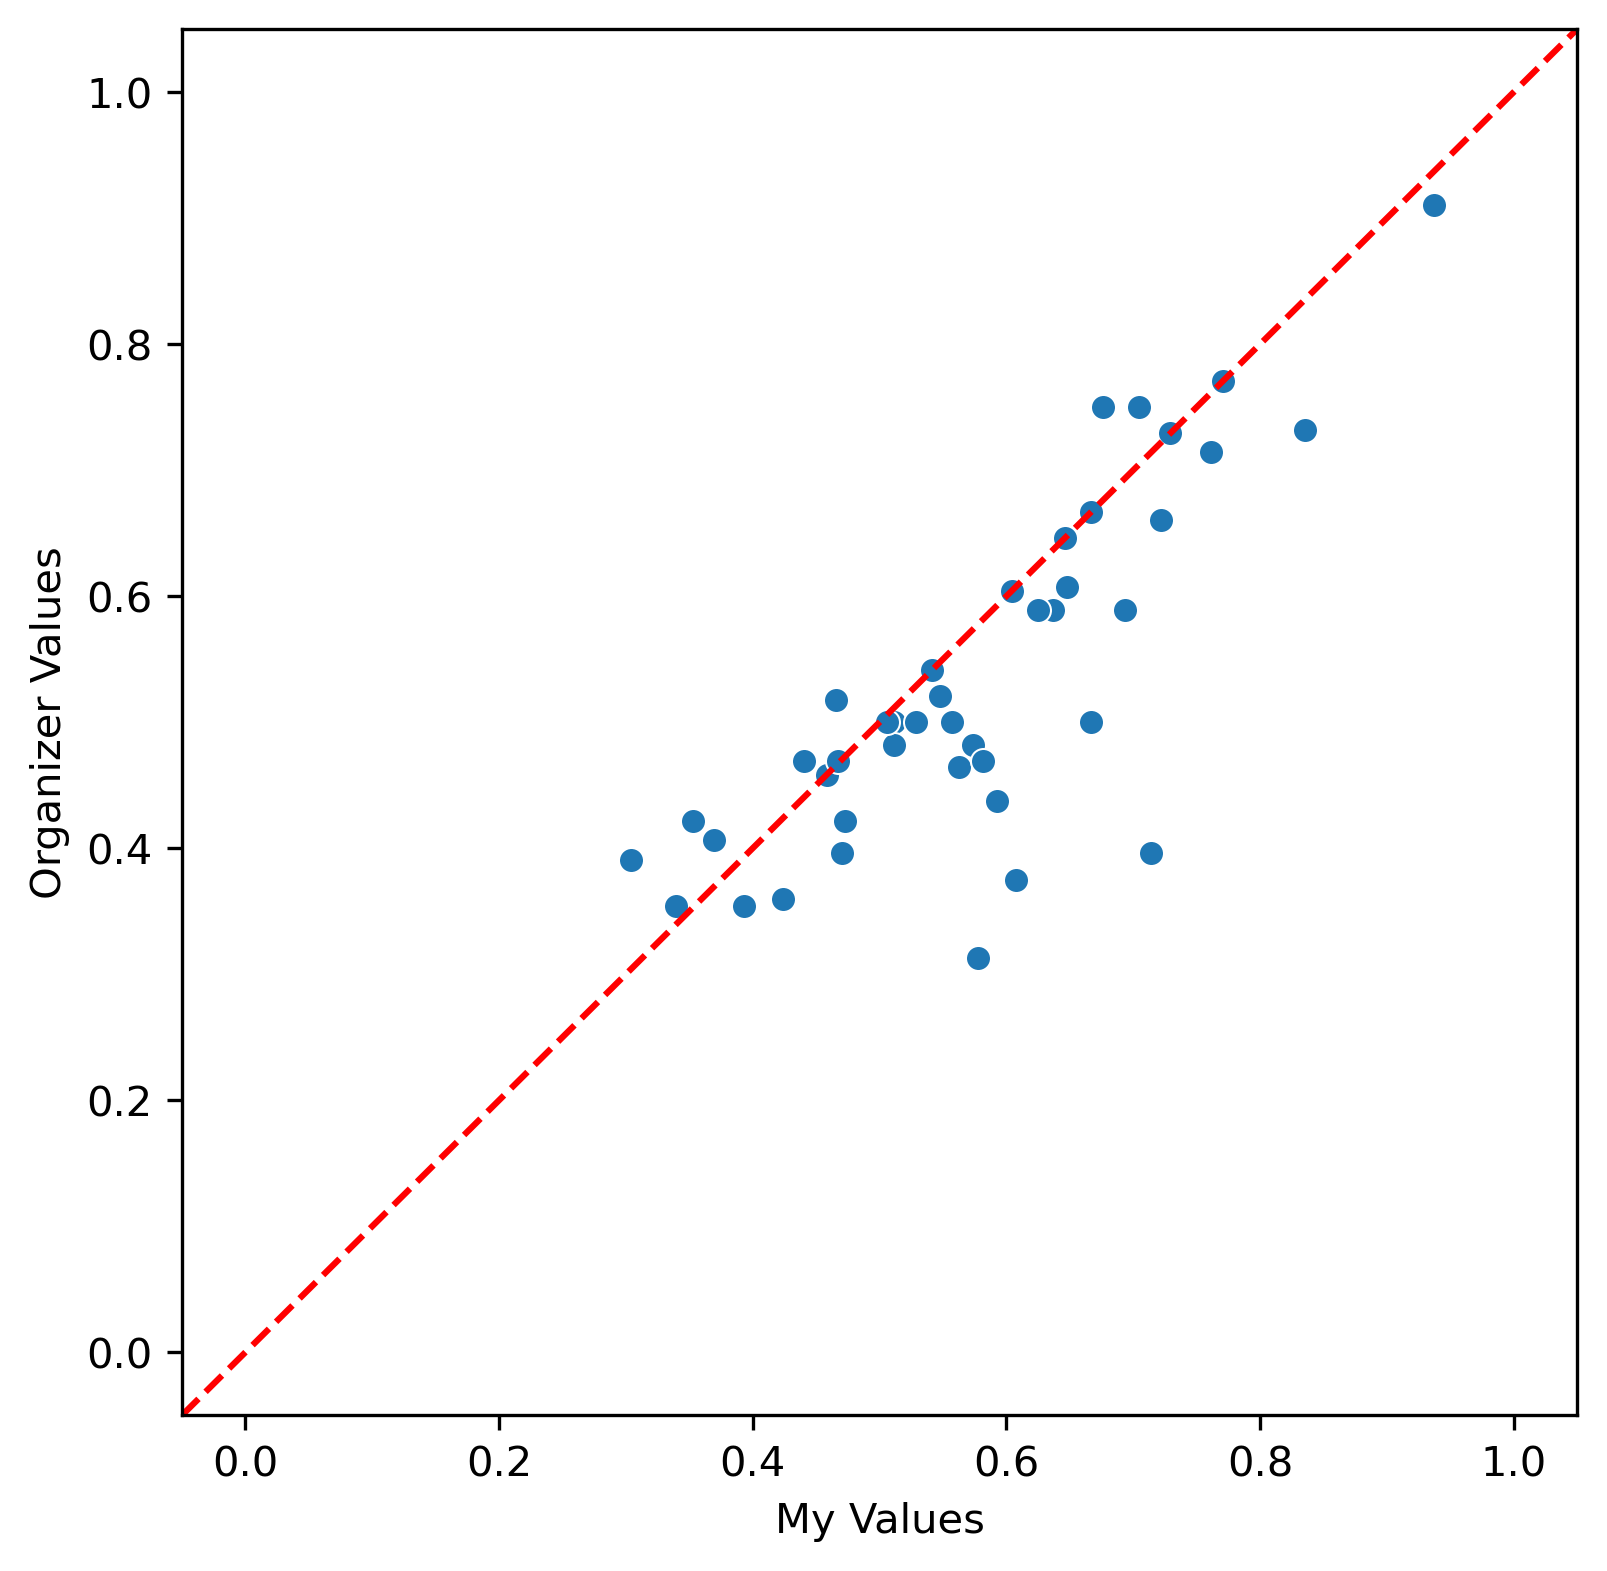

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.scatterplot(data=merged_df, x='Correct_Ratio', y='Experimental Values', ax=ax)
g.set(xlabel='My Values', ylabel='Organizer Values')
ax.axline([0, 0], [1, 1], color='red', linestyle='--')

In [106]:
test_df = ravia_2_behavior[(ravia_2_behavior['Stimulus 1'] == 'M1') & (ravia_2_behavior['Stimulus 2'] == 'M11')]

test_df['IsCorrect'].sum()/len(test_df)

0.7045454545454546

In [72]:
ravia_2_stimuli

,Stimulus,Type,Experiment,CID,ID,Compared To ID,ID In Exp 1,ID In Exp 2,Dilution1,Dilution2,Dilution3
0,0,mono-molecule,Exp1,7519,NaN,NaN,1,NaN,100.00%,NaN,NaN
1,1,mono-molecule,Exp1,7770,NaN,NaN,2,NaN,100.00%,NaN,NaN
2,2,mono-molecule,Exp1,1140,NaN,NaN,3,NaN,100.00%,NaN,NaN
3,3,mono-molecule,Exp1,8030,NaN,NaN,4,NaN,100.00%,NaN,NaN
4,4,mono-molecule,Exp1,8103,NaN,NaN,5,NaN,100.00%,NaN,NaN
5,5,mono-molecule,Exp1,8129,NaN,NaN,6,NaN,100.00%,NaN,NaN
6,6,mono-molecule,Exp1,957,NaN,NaN,7,NaN,100.00%,NaN,NaN
7,7,mono-molecule,Exp1,4133,NaN,NaN,8,NaN,100.00%,NaN,NaN
8,8,mono-molecule,Exp1,31252,NaN,NaN,9,NaN,100.00%,NaN,NaN
9,9,mono-molecule,Exp1,31276,NaN,NaN,10,NaN,10.00%,NaN,NaN


In [59]:
testing = ravia_2[(ravia_2.index == 289) & (ravia_2['Stimulus 2'] == 299)]['IsCorrect']
#testing = ravia_2[(ravia_2.index == 285) & (ravia_2['Stimulus 2'] == 295) | (ravia_2.index == 285) & (ravia_2['Stimulus 2'] == 285)]['IsCorrect']

testing.sum()/len(testing)

0.7215909090909091

In [45]:
ravia_2[ravia_2[(ravia_2.index == 285) & (ravia_2['Stimulus 2'] == 295)]['Subject'].str.isupper()]

/tmp/ipykernel_9347/2528656920.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ravia_2[ravia_2[(ravia_2.index == 285) & (ravia_2['Stimulus 2'] == 295)]['Subject'].str.isupper()]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [49]:
test = ravia_2[(ravia_2.index == 285) & (ravia_2['Stimulus 2'] == 295)]
               
mask = test['Subject'].str.match(r'^[A-Z0-9]+$')

subset = test[mask]

In [61]:
ravia_2.head(4)

,Stimulus 2,Subject,TrialOrderInSession,Choice,CorrectChoiceOnScreen,IsCorrect,RT_Discrimination,Confidence,RT_Confidence
Stimulus 1,,,,,,,,,
285,285,M101,1,0,1,0,15.820587,0.965318,1.578485
285,285,M101,1,1,1,1,31.344349,0.502312,1.667771
285,285,M438,1,1,1,1,13.146231,0.726012,1.512166
285,285,M438,1,1,1,1,11.956795,0.693064,2.898439
